### A.1 scinder le fichier de façon à ce que BD[i] corresponde aux données de l’action i, puis calculer ER, qui est une liste de 12 éléments, chacun représentant le taux de rendement attendu de chaque action.


In [1]:
# contenu de excel "Actif","Dates","Ouverture","Max","Min","Fermeture","Volume"
import numpy as np
import numpy.linalg as cm
import pandas as pd
import glob


file_list = glob.glob("actions/*.xlsm")
BD = [pd.read_excel(file, engine="openpyxl") for file in file_list]

# ER est un vecteur de taille 12 qui contient les rendements moyens des 12 actions
ER = np.ones((12, 1))
for j in range(12):
    bd = BD[j]
    St = [
        (bd.iloc[i, 3] + bd.iloc[i, 4]) / 2 for i in range(255)
    ]  # St est le prix moyen de chaque action
    Rt = [
        (St[i + 1] / St[i]) - 1 for i in range(254)
    ]  # Rt est le rendement de chaque action
    ER[j] = np.mean(Rt)  # ER[j] est le rendement moyen de l'action j

### A.2 Calculer dans la fonction de la frontière efficiente les paramètres

La formule est la suivante : $$m_{\sigma} = \frac{b}{a} + \sqrt{\sigma^2 - \frac{1}{a}} \times norm$$
où $$m_{\sigma}$$ représente le rendement espéré maximal correspondant à la valeur de 𝜎


In [2]:
# SIGMA est la matrice de covariance des rendements des 12 actions
SIGMA = np.ones((12, 12))

for i in range(12):
    for j in range(12):
        bdi = BD[i]
        Sti = [(bdi.iloc[k, 3] + bdi.iloc[k, 4]) / 2 for k in range(255)]
        Rti = [
            (Sti[k + 1] / Sti[k]) - 1 for k in range(254)
        ]  # Rti est les rendements de l'action i
        RtiC = np.array(Rti) - ER[i]  # RtiC est le rendement de l'action i centré

        bdj = BD[j]
        Stj = [(bdj.iloc[k, 3] + bdj.iloc[k, 4]) / 2 for k in range(255)]
        Rtj = [
            Stj[k + 1] / Stj[k] - 1 for k in range(254)
        ]  # Rtj est le rendement de l'action j
        RtjC = np.array(Rtj) - ER[j]

        SIGMA[i, j] = np.mean(RtiC * RtjC)


print("Détérminant de sigma :", cm.det(SIGMA))
assert cm.det(SIGMA) != 0
sigmainv = cm.inv(SIGMA)

vect1 = np.ones((12, 1))
vect1T = vect1.T

a = vect1T @ sigmainv @ vect1
a = a[0][0]
print("a: ", a)

b = vect1T @ sigmainv @ ER
b = b[0][0]
print("b: ", b)

Vect = ER - (b / a) * vect1
norm2 = Vect.T @ sigmainv @ Vect
norm = np.sqrt(norm2)[0][0]
print("Norm: ", norm)
valsigma = np.linspace(1 / a, 2 / a, 100)

Détérminant de sigma : 1.7470455596539675e-48
a:  22541.52841897661
b:  -4.842703763275818
Norm:  0.25708574674943396


### A.3.Tracer les 3 courbes correspondantes


Text(0.5, 0, 'sigma')

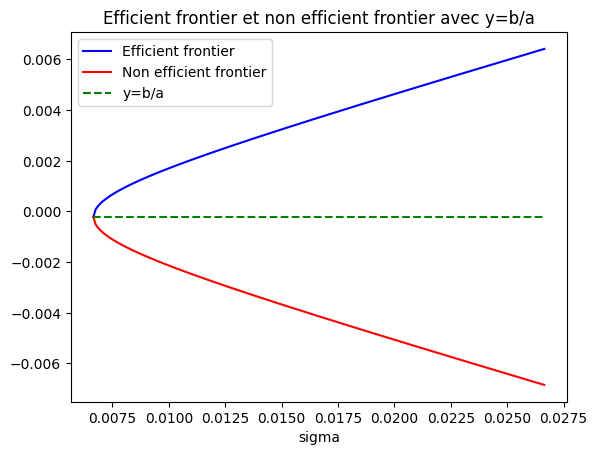

In [3]:
import matplotlib.pyplot as plt


# frontière efficiente


def FE(a, b, sigma, norm):

    y = b / a + np.sqrt(sigma**2 - 1 / a) * norm

    return y


# frontière non efficiente


def FNE(a, b, sigma, norm):

    y = b / a - np.sqrt(sigma**2 - 1 / a) * norm

    return y


# constante


def cste(a, b):

    y = b / a

    return y


axesigma = np.linspace(1 / np.sqrt(a), 4 / np.sqrt(a), 200)


axeFE = [FE(a, b, sigma, norm) for sigma in axesigma]


axeFNE = [FNE(a, b, sigma, norm) for sigma in axesigma]


axeCste = [cste(a, b) for sigma in axesigma]


plt.title("Efficient frontier et non efficient frontier avec y=b/a")


plt.plot(axesigma, axeFE, label="Efficient frontier", color="blue")


plt.plot(axesigma, axeFNE, label="Non efficient frontier", color="red")


plt.plot(axesigma, axeCste, label="y=b/a", color="green", linestyle="--")


plt.legend()
plt.xlabel("sigma")

### A.4.Générer aléatoirement 𝑋 (c’est-à-dire la répartition en pourcentages pour chacun des 12 actions). L’axe des abscisses représente l’écart-type σ du portefeuille, et l’axe des ordonnées représente le rendement espéré ER.


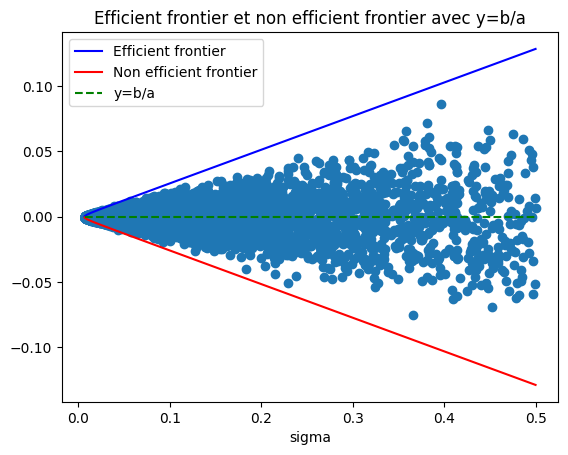

In [4]:
# point de nuage
import numpy.random as npr

NS = 50000
Axe1 = []
Axe2 = []
for j in range(NS):
    x = npr.randn(12)  # gnere 12 valeurs aléatoires normales
    s = np.sum(x)
    if s == 0:
        x[0] += 1
    else:
        x = x / s

    esp = x.T @ ER
    var = x.T @ SIGMA @ x
    sig = np.sqrt(var)

    if sig <= 0.5:
        Axe1.append(sig)
        Axe2.append(esp)

plt.scatter(Axe1, Axe2)

axesigma = np.linspace(min(Axe1), max(Axe1), 200)
axeFE = [FE(a, b, sigma, norm) for sigma in axesigma]
axeFNE = [FNE(a, b, sigma, norm) for sigma in axesigma]
axeCste = [cste(a, b) for sigma in axesigma]

plt.title("Efficient frontier et non efficient frontier avec y=b/a")
plt.plot(axesigma, axeFE, label="Efficient frontier", color="blue")
plt.plot(axesigma, axeFNE, label="Non efficient frontier", color="red")
plt.plot(axesigma, axeCste, label="y=b/a", color="green", linestyle="--")
plt.legend()
plt.xlabel("sigma")
plt.show()

### A.5. Répéter la simulation avec des poids générés aléatoirement, puis sélectionner les poids optimaux (critère de filtrage : $\sigma \le \sigma_{\max}$)


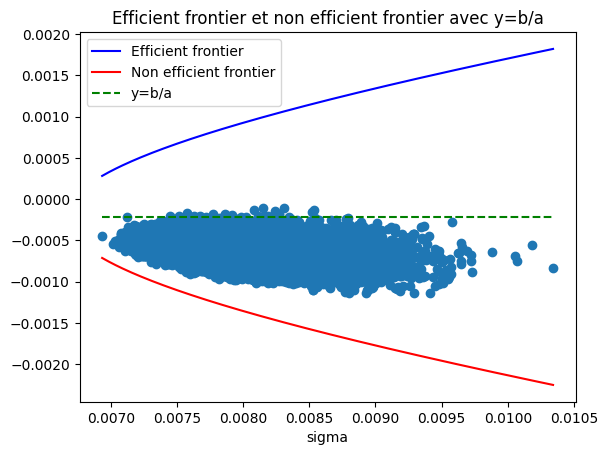

Portefeuille optimal x_opt :
[0.07290681 0.02018553 0.0004817  0.04426862 0.06244576 0.22005381
 0.18351858 0.18763156 0.00910237 0.06751606 0.01190774 0.11998145]
Rendement espéré correspondant : [-0.00010082]
Sigma correspondante : 0.1


In [5]:
import numpy as np
import numpy.random as npr

# choix de sigma
Sigmax = 0.1  # contrainte de risque
Espmax = -10 * 10  # initialisation le rendement maximal

# initialisation du vecteur de poids optimal
x_opt = np.array([1 for _ in range(12)])
Axe1 = []
Axe2 = []

for _ in range(NS):
    # générer un vecteur de poids aléatoires
    x = [npr.uniform() for _ in range(12)]  # uniforme sur [0, 1]
    x = np.array(x)  # convertir en tableau numpy
    s = np.sum(x)  # somme des poids

    #  pas égal à 0
    if s == 0:
        x[0] = 1  # si la somme des poids est nulle, on met le premier poids à 1
    else:
        x = x / s  # normaliser les poids

    # calculer le rendement et le variance
    var = x.T @ SIGMA @ x
    sig = np.sqrt(var)
    esp = x.T @ ER

    Axe1.append(sig)
    Axe2.append(esp)

    # vérifier si la contrainte de risque est satisfaite

    if sig <= Sigmax:
        # vérifier si le rendement est supérieur à l'ancien rendement maximal
        if esp > Espmax:
            Espmax = esp  # mettre à jour le rendement maximal
            x_opt = x  # mettre à jour le vecteur de poids optimal

plt.scatter(Axe1, Axe2)

axesigma = np.linspace(min(Axe1), max(Axe1), 200)
axeFE = [FE(a, b, sigma, norm) for sigma in axesigma]
axeFNE = [FNE(a, b, sigma, norm) for sigma in axesigma]
axeCste = [cste(a, b) for sigma in axesigma]

plt.title("Efficient frontier et non efficient frontier avec y=b/a")
plt.plot(axesigma, axeFE, label="Efficient frontier", color="blue")
plt.plot(axesigma, axeFNE, label="Non efficient frontier", color="red")
plt.plot(axesigma, axeCste, label="y=b/a", color="green", linestyle="--")
plt.legend()
plt.xlabel("sigma")
plt.show()

print("Portefeuille optimal x_opt :")
print(x_opt)
print(f"Rendement espéré correspondant : {Espmax}")
print(f"Sigma correspondante : {Sigmax}")

### A.6 bonus. Répéter la simulation avec des poids générés aléatoirement, puis sélectionner les poids optimaux (critère de filtrage : $$ \mathrm{VaR}\_{95}(R^x) \le \frac{2}{100}$$）


In [6]:
import numpy as np
import numpy.random as npr

# calculate the return matrix R (12, 254)
R = np.zeros((12, 254))
for j in range(12):
    bd = BD[j]
    St = [(bd.iloc[i, 3] + bd.iloc[i, 4]) / 2 for i in range(255)]
    R[j, :] = [(St[i + 1] / St[i]) - 1 for i in range(254)]

# choix de VaR_max
VaR_max = 2 / 100  # !!!VaR constraint
Espmax = -np.inf  # initial maximum expected return

# initial optimal portfolio
x_opt = np.array([1 for _ in range(12)])

# random search for optimal portfolio
for _ in range(NS):
    # random generate weights
    x = [npr.uniform() for _ in range(12)]  # generate weights from uniform distribution
    x = np.array(x)  # convert to numpy array
    s = np.sum(x)  #    sum of weights

    # make sure the sum of weights is not 0
    if s == 0:
        x[0] = 1  #  if the sum of weights is 0, set the first weight to 1
    else:
        x = x / s  # normalize weights

    #  calculate the expected return
    R_x = x.T @ R  # R_x is the return of the portfolio

    # calculate the 95% VaR
    VaR_95 = np.quantile(-R_x, 0.95)  #!!!!

    #   check if the VaR constraint is satisfied
    if VaR_95 <= VaR_max:
        esp = x.T @ ER  #  calculate the expected return
        if esp > Espmax:
            Espmax = esp
            x_opt = x  # update the optimal portfolio

# output the result

print("Portefeuille optimal x_opt :")
print(x_opt)
print(f"Rendement espéré correspondant : {Espmax}")
print(f"VaR_95 correspondante : {VaR_95}")

Portefeuille optimal x_opt :
[0.04621201 0.02259151 0.00839164 0.01715481 0.00319367 0.13860879
 0.22557681 0.12394679 0.00712716 0.2239845  0.06049464 0.12271766]
Rendement espéré correspondant : [-0.00011149]
VaR_95 correspondante : 0.014355896123511585


### B.1 Extraction des données de l'année 2019

### BD2019[i] représente la liste des prix de l'action i en 2019.


In [7]:
# genere un BD qui contient seulement les données de 2019
BD2019 = []

for df in BD:
    # convertir la colonne de date en format datetime

    df.iloc[:, 1] = pd.to_datetime(
        df.iloc[:, 1], format="%d/%m/%Y"
    )  # iloc[:, 1] choisi la colonne de date
    # filtrer les données de 2019
    df_2019 = df[df.iloc[:, 1].dt.year == 2019]
    BD2019.append(df_2019)

# vérification
for i, df in enumerate(BD2019):  # enumerate() retourne un objet énumérant
    print(f"File {i+1} - Number of rows: {len(df)}")
    print(df.head())

File 1 - Number of rows: 245
     FR0000120404 2018-01-02 00:00:00  43.21  43.51  42.85  43.48   966332
254  FR0000120404          2019-01-02  36.94  36.94  36.04  36.60   562162
255  FR0000120404          2019-01-03  36.39  36.55  36.00  36.00   800687
256  FR0000120404          2019-01-04  36.41  37.03  36.17  36.84  1074737
257  FR0000120404          2019-01-07  37.02  37.02  36.44  37.00   554260
258  FR0000120404          2019-01-08  37.10  37.46  36.87  37.09   720341
File 2 - Number of rows: 245
     FR0000120628 2018-01-02 00:00:00    24.8  24.805   24.47   24.76  \
254  FR0000120628          2019-01-02  18.620  18.816  18.428  18.806   
255  FR0000120628          2019-01-03  18.626  18.950  18.612  18.650   
256  FR0000120628          2019-01-04  18.792  19.294  18.718  19.236   
257  FR0000120628          2019-01-07  19.282  19.380  19.038  19.150   
258  FR0000120628          2019-01-08  19.212  19.474  19.158  19.222   

      5193046  
254   8028529  
255   6583413  
256  

###


### B.2 Donner un capital initial de 10^5, appliquer x_opt comme pourcentage initial, ajuster la position à chaque instant, puis calculer \(C_t\) pour chaque valeur de \(t\).


[0.04621201 0.02259151 0.00839164 0.01715481 0.00319367 0.13860879
 0.22557681 0.12394679 0.00712716 0.2239845  0.06049464 0.12271766]
[100000, np.float64(100054.579), np.float64(101277.294), np.float64(102265.0365), np.float64(102770.74650000001), np.float64(103102.179), np.float64(102656.91900000002), np.float64(102956.7925), np.float64(101848.0135), np.float64(102150.779), np.float64(102244.6), np.float64(102125.81), np.float64(103451.205), np.float64(103512.15250000001), np.float64(103123.7525), np.float64(102956.9575), np.float64(102797.435), np.float64(104000.72750000001), np.float64(103629.265), np.float64(103940.22999999998), np.float64(104825.12999999998), np.float64(105927.89749999996), np.float64(106472.30749999997), np.float64(106423.46249999998), np.float64(107001.83999999998), np.float64(107512.27249999999), np.float64(106564.45749999997), np.float64(105403.56349999996), np.float64(106128.60199999997), np.float64(107054.49949999998), np.float64(107119.94699999997), np.flo

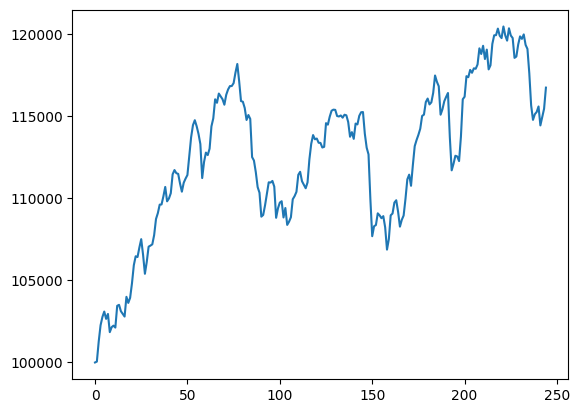

In [9]:
# initialiser le capital
C = 100000

Ct = [C]

S = [[] for _ in range(12)]  # liste vide pour stocker les prix des actions

for i in range(12):
    S[i] = [
        (BD2019[i].iloc[j, 3] + BD2019[i].iloc[j, 4]) / 2 for j in range(len(BD2019[i]))
    ]  # S[i] est la liste des prix de l'action i en 2019

S0 = np.array(
    [S[i][0] for i in range(12)]
)  # S0 contient les prix de chaque action le premier jour de 2019

theta = np.array(
    [int(C * x_opt[i] / S0[i]) for i in range(12)]
)  # theta est le nombre d'actions initiales, c'est-à-dire le nombre initial d'actions achetées pour chaque action, capital total * pourcentage / prix
cash = C - theta.T @ S0  # cash est le capital restant après l'achat des actions
# print("Prix des actions après le 1er jour :", np.dot(theta, S0))
# print("Montant de trésorerie restant après le 1er jour :", cash)
# CashList = [cash]  # Stocke la trésorerie correspondante à chaque instant t

# deuxième jour à la fin de 2019
for t in range(1, len(BD2019[0])):  # len(BD2019[0])est le nombre de jours en 2019

    # 1.calculer le nouveau capital
    St = np.array(
        [S[i][t] for i in range(12)]
    )  # St contient les prix de chaque action le jour t de 2019
    C = cash + theta.T @ St
    # cash est le capital à l'instant t-1, thetaT est la quantité détenue à l'instant t-1, St est le prix de l'action à l'instant t
    # 2.calculer la nouvelle quantité d'actions
    theta = np.array([int(C * x_opt[i] / S[i][t]) for i in range(12)])
    # 3.calculer le nouveau capital restant
    cash = C - theta.T @ St
    Ct.append(C)
print(x_opt)
# print(CashList)
plt.plot(Ct)
print(Ct)

## C. Appliquer la prix de transaction

**Soit** k un coût de transaction $$(k = \tfrac{S}{100}\bigr).(initial)$$

On définit la valeur du portefeuille après transaction à l’instant \(t\) comme :

$$
C_t \;=\; C \;-\; \mathrm{Cout_t}
$$

où le coût de transaction \(\mathrm{Cout}\_t\) s’écrit :

$$
\mathrm{Cout}_t
\;=\;
\sum_{i}
\Bigl|\theta_{\mathrm{ancienne}}^{\,i} \;-\; \theta_{\mathrm{nouveaux}}^{\,i}\Bigr|
\,\times\, S_t^i
\,\times\, k.
$$

---

**Projet :**

- $ k = \frac{S}{100} $ (faire varier …)
- $ f(\sigma*{\max}) $ : faire varier $\sigma*{\max}$
- Étude complète du problème : « Combien avez-vous gagné ? »
- Possibilité de choisir d’autres actions.


In [ ]:
# initialiser le capital
C = 100000
Ct = [C]
k = 5 / 100

theta = np.array(
    [int(C * x_opt[i] / S0[i]) for i in range(12)]
)  # theta est le nombre d'actions initiales, c'est-à-dire le nombre initial d'actions achetées pour chaque action, capital total * pourcentage / prix
fare = theta.T @ S0
cash = C - theta.T @ S0  # cash est le capital restant après l'achat des actions
# print("Prix des actions après le 1er jour :", np.dot(theta, S0))
# print("Montant de trésorerie restant après le 1er jour :", cash)
# CashList = [cash]  # Stocke la trésorerie correspondante à chaque instant t

# deuxième jour à la fin de 2019
for t in range(1, len(BD2019[0])):  # len(BD2019[0])est le nombre de jours en 2019

    # 1.calculer le nouveau capital
    St = np.array(
        [S[i][t] for i in range(12)]
    )  # St contient les prix de chaque action le jour t de 2019
    C = cash + theta.T @ St
    # cash est le capital à l'instant t-1, thetaT est la quantité détenue à l'instant t-1, St est le prix de l'action à l'instant t
    # 2.calculer la nouvelle quantité d'actions
    theta = np.array([int(C * x_opt[i] / S[i][t]) for i in range(12)])
    # 3.calculer le nouveau capital restant
    cash = C - theta.T @ St
    Ct.append(C)

# print(CashList)
plt.plot(Ct)